In [1]:
from __future__ import print_function

### TensorFlow Arhictecture

![A](image6.png)

### Load Libraries

In [2]:
import os
import sys
sys.path.append('../')

import tensorflow as tf
from models.cnn_model import CNN_Model
from data.data_pipeline import get_input_fn
from hparams.yparams import YParams
from parse_tensorboard_tfevents import get_training_history

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('demo_style.mplstyle')

### Create model_fn

In [3]:
def model_fn(features, labels, params, mode):
    """ Build graph and return EstimatorSpec """

    is_training = (mode == tf.estimator.ModeKeys.TRAIN)

    model = CNN_Model(params, input_x=features, is_training=is_training)

    if mode is not tf.estimator.ModeKeys.PREDICT:
        # loss and optimizer are not needed for inference
        model.define_loss(labels)
        model.define_optimizer()

    with tf.variable_scope('eval_metrics') as _:
        eval_metrics = {}
        probs = tf.nn.sigmoid(model.logits)
        predictions = tf.round(probs)
        eval_metrics['acc'] = tf.metrics.accuracy(labels=labels, predictions=predictions)

    return tf.estimator.EstimatorSpec(loss=model.loss,
                                      train_op=model.optimizer,
                                      eval_metric_ops=eval_metrics,
                                      mode=mode)

### load parameters

In [4]:
configurations_path = '../hparams/cnn.yaml'
experiment = 'demo_single_node'
params = YParams(configurations_path, experiment)

train_dataset_size 128000
valid_dataset_size 64000
train_data_files ../data/train.h5
valid_data_files ../data/valid.h5
epochs 5
experiment_dir ../logs/demo_single_node
data_format channels_last
input_shape ['None', 64, 64, 1]
conv_filters [16, 32, 64]
conv_args CommentedMap([('kernel_size', 3), ('strides', 1), ('padding', 'same'), ('activation', 'relu')])
maxpool_args CommentedMap([('pool_size', 2), ('strides', 2)])
conv_dropout_rate 0.2
fc_hidden_units [256]
fc_dropout_rates [0.2]
fc_activation relu
learning_rate 0.001
batchsize 128


### Create data pipelines

In [5]:
# create training data input pipeline
train_input_fn, train_init_hook = get_input_fn(params.train_data_files,
                                               dataset_size=params.train_dataset_size,
                                               batchsize=params.batchsize,
                                               epochs=params.epochs,
                                               variable_scope='train_data_pipeline')

max_steps = (params.train_dataset_size//params.batchsize)*params.epochs
train_spec = tf.estimator.TrainSpec(input_fn=train_input_fn,
                                    hooks=[train_init_hook],
                                    max_steps=max_steps)

# create validation data input pipeline
valid_input_fn, valid_init_hook = get_input_fn(params.valid_data_files,
                                               dataset_size=params.valid_dataset_size,
                                               batchsize=params.batchsize,
                                               epochs=params.epochs,
                                               variable_scope='valid_data_pipeline')

eval_spec = tf.estimator.EvalSpec(input_fn=valid_input_fn,
                                  hooks=[valid_init_hook],
                                  start_delay_secs=10,
                                  throttle_secs=15)

### Build estimator

In [6]:
config = tf.estimator.RunConfig(save_checkpoints_secs=20) # too frequent, just for demo

In [7]:
estimator = tf.estimator.Estimator(model_fn=model_fn,
                                   model_dir=params.experiment_dir,
                                   config=config,
                                   params=params)

INFO:tensorflow:Using config: {'_is_chief': True, '_num_worker_replicas': 1, '_save_checkpoints_secs': 20, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fd0792fce80>, '_device_fn': None, '_save_checkpoints_steps': None, '_task_type': 'worker', '_model_dir': '../logs/demo_single_node', '_tf_random_seed': None, '_train_distribute': None, '_keep_checkpoint_max': 5, '_master': '', '_evaluation_master': '', '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_global_id_in_cluster': 0, '_log_step_count_steps': 100, '_session_config': None, '_save_summary_steps': 100}


### Train Model

In [8]:
tf.logging.set_verbosity(tf.logging.INFO)
tf.estimator.train_and_evaluate(estimator, train_spec, eval_spec)

INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps None or save_checkpoints_secs 20.
INFO:tensorflow:Calling model_fn.
Number of model parameters 1072385
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into ../logs/demo_single_node/model.ckpt.
INFO:tensorflow:loss = 0.692996, step = 0
INFO:tensorflow:global_step/sec: 78.3305
INFO:tensorflow:loss = 0.255566, step = 100 (1.278 sec)
INFO:tensorflow:global_step/sec: 88.9762
INFO:tensorflow:loss = 0.206599, step = 200 (1.124 sec)
INFO:tensorflow:global_step/sec: 85.7971
INFO:tensorflow:loss = 0.1885, step = 300 (1.165 sec)
INFO:tensorflow:globa

INFO:tensorflow:Evaluation [80/100]
INFO:tensorflow:Evaluation [90/100]
INFO:tensorflow:Evaluation [100/100]
INFO:tensorflow:Finished evaluation at 2018-08-30-02:45:44
INFO:tensorflow:Saving dict for global step 4734: acc = 0.983594, global_step = 4734, loss = 0.0443908
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 4734: ../logs/demo_single_node/model.ckpt-4734
INFO:tensorflow:global_step/sec: 29.9216
INFO:tensorflow:loss = 0.0148298, step = 4800 (3.342 sec)
INFO:tensorflow:global_step/sec: 84.5477
INFO:tensorflow:loss = 0.0635375, step = 4900 (1.183 sec)
INFO:tensorflow:Saving checkpoints for 5000 into ../logs/demo_single_node/model.ckpt.
INFO:tensorflow:Skip the current checkpoint eval due to throttle secs (15 secs).
INFO:tensorflow:Calling model_fn.
Number of model parameters 1072385
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-08-30-02:45:48
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../log

({'acc': 0.98140627, 'global_step': 5000, 'loss': 0.050155796}, [])

### Examine learning curves

In [9]:
train_hist, valid_hist = get_training_history(model_dir=params.experiment_dir)

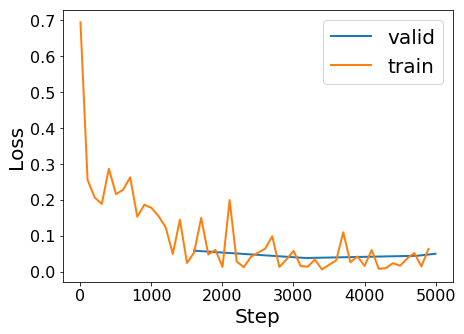

In [10]:
plt.plot(valid_hist['loss']['steps'], valid_hist['loss']['values'], label='valid');
plt.plot(train_hist['loss']['steps'], train_hist['loss']['values'], label='train');
plt.ylabel('Loss');
plt.xlabel('Step');
plt.legend(loc=1);

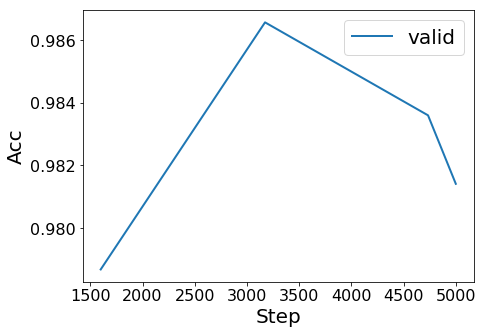

In [11]:
plt.plot(valid_hist['acc']['steps'], valid_hist['acc']['values'], label='valid');
plt.ylabel('Acc');
plt.xlabel('Step');
plt.legend(loc=0);

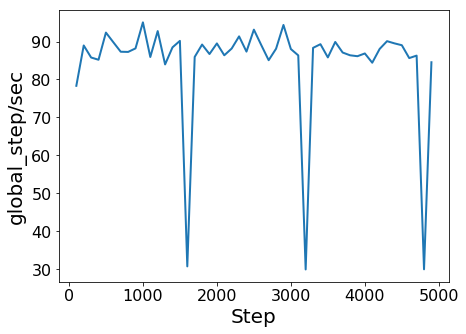

In [12]:
plt.plot(train_hist['global_step/sec']['steps'], train_hist['global_step/sec']['values']);
plt.ylabel('global_step/sec');
plt.xlabel('Step');